# Submission Draft for San Francisco Crime Classification - MLP

https://www.kaggle.com/c/sf-crime

In [14]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

%reload_ext autoreload
%autoreload 2
from src.features.build_features import DataFrameSelector, SFCCTransformer, print_summary, prep_submissions, prep_data

import inspect

In [15]:
train_pd = pd.read_csv("~/Desktop/w207re-final-proj/data/raw/train.csv.zip", compression="zip")
test_pd = pd.read_csv("~/Desktop/w207re-final-proj/data/raw/test.csv.zip", compression="zip")

In [16]:
sfcc = SFCCTransformer()
pipe = Pipeline([
    ("transformer", sfcc)
])
train_pd = pipe.transform(train_pd)
test_pd = pipe.transform(test_pd)

In [17]:
train_data, train_labels, dev_data, dev_labels, test_data, test_ids = prep_data(train_pd, test_pd, rs = 42, dev_size=0.1)

In [18]:
from sklearn.neural_network import MLPClassifier

selector = DataFrameSelector(["X", "Y"])
clf = MLPClassifier(verbose=True)


pipe = Pipeline([
    ("selector", selector)
    ,("clf", clf)
])

param_grid = {
    "selector__attribute_names": [
        ["X","Y","is_weekend", 'pdd_BAYVIEW', 'pdd_CENTRAL', 'pdd_INGLESIDE',
       'pdd_MISSION', 'pdd_NORTHERN', 'pdd_PARK', 'pdd_RICHMOND',
       'pdd_SOUTHERN', 'pdd_TARAVAL', 'pdd_TENDERLOIN', "is_latenight", "month_of_year_sin"]
    ]
    ,"clf__hidden_layer_sizes": [(100, 50, 100)]
}

search = GridSearchCV(pipe, param_grid, iid = True, cv = 3, return_train_score = False, n_jobs=-1, scoring='neg_log_loss', verbose=1)

_ = search.fit(train_data, train_labels)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 1086.6min finished


Iteration 1, loss = 2.61066925
Iteration 2, loss = 2.58344710
Iteration 3, loss = 2.56044162
Iteration 4, loss = 2.54534577
Iteration 5, loss = 2.53769907
Iteration 6, loss = 2.53193188
Iteration 7, loss = 2.52712466
Iteration 8, loss = 2.52299313
Iteration 9, loss = 2.51956885
Iteration 10, loss = 2.51628750
Iteration 11, loss = 2.51363472
Iteration 12, loss = 2.51156691
Iteration 13, loss = 2.50972962
Iteration 14, loss = 2.50814894
Iteration 15, loss = 2.50649279
Iteration 16, loss = 2.50535204
Iteration 17, loss = 2.50386701
Iteration 18, loss = 2.50299377
Iteration 19, loss = 2.50192703
Iteration 20, loss = 2.50108012
Iteration 21, loss = 2.50064792
Iteration 22, loss = 2.49924023
Iteration 23, loss = 2.49861992
Iteration 24, loss = 2.49776417
Iteration 25, loss = 2.49735962
Iteration 26, loss = 2.49650483
Iteration 27, loss = 2.49591030
Iteration 28, loss = 2.49541239
Iteration 29, loss = 2.49477011
Iteration 30, loss = 2.49415592
Iteration 31, loss = 2.49387842
Iteration 32, los

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [19]:
pred_labels = search.predict(dev_data)

Normalized confusion matrix
[[0.         0.125      0.         ... 0.03571429 0.         0.        ]
 [0.         0.05005241 0.         ... 0.02148847 0.         0.        ]
 [0.         0.         0.         ... 0.02439024 0.         0.        ]
 ...
 [0.         0.03172205 0.         ... 0.06382175 0.         0.        ]
 [0.         0.02609108 0.         ... 0.0085389  0.         0.        ]
 [0.         0.08457143 0.         ... 0.01828571 0.         0.        ]]


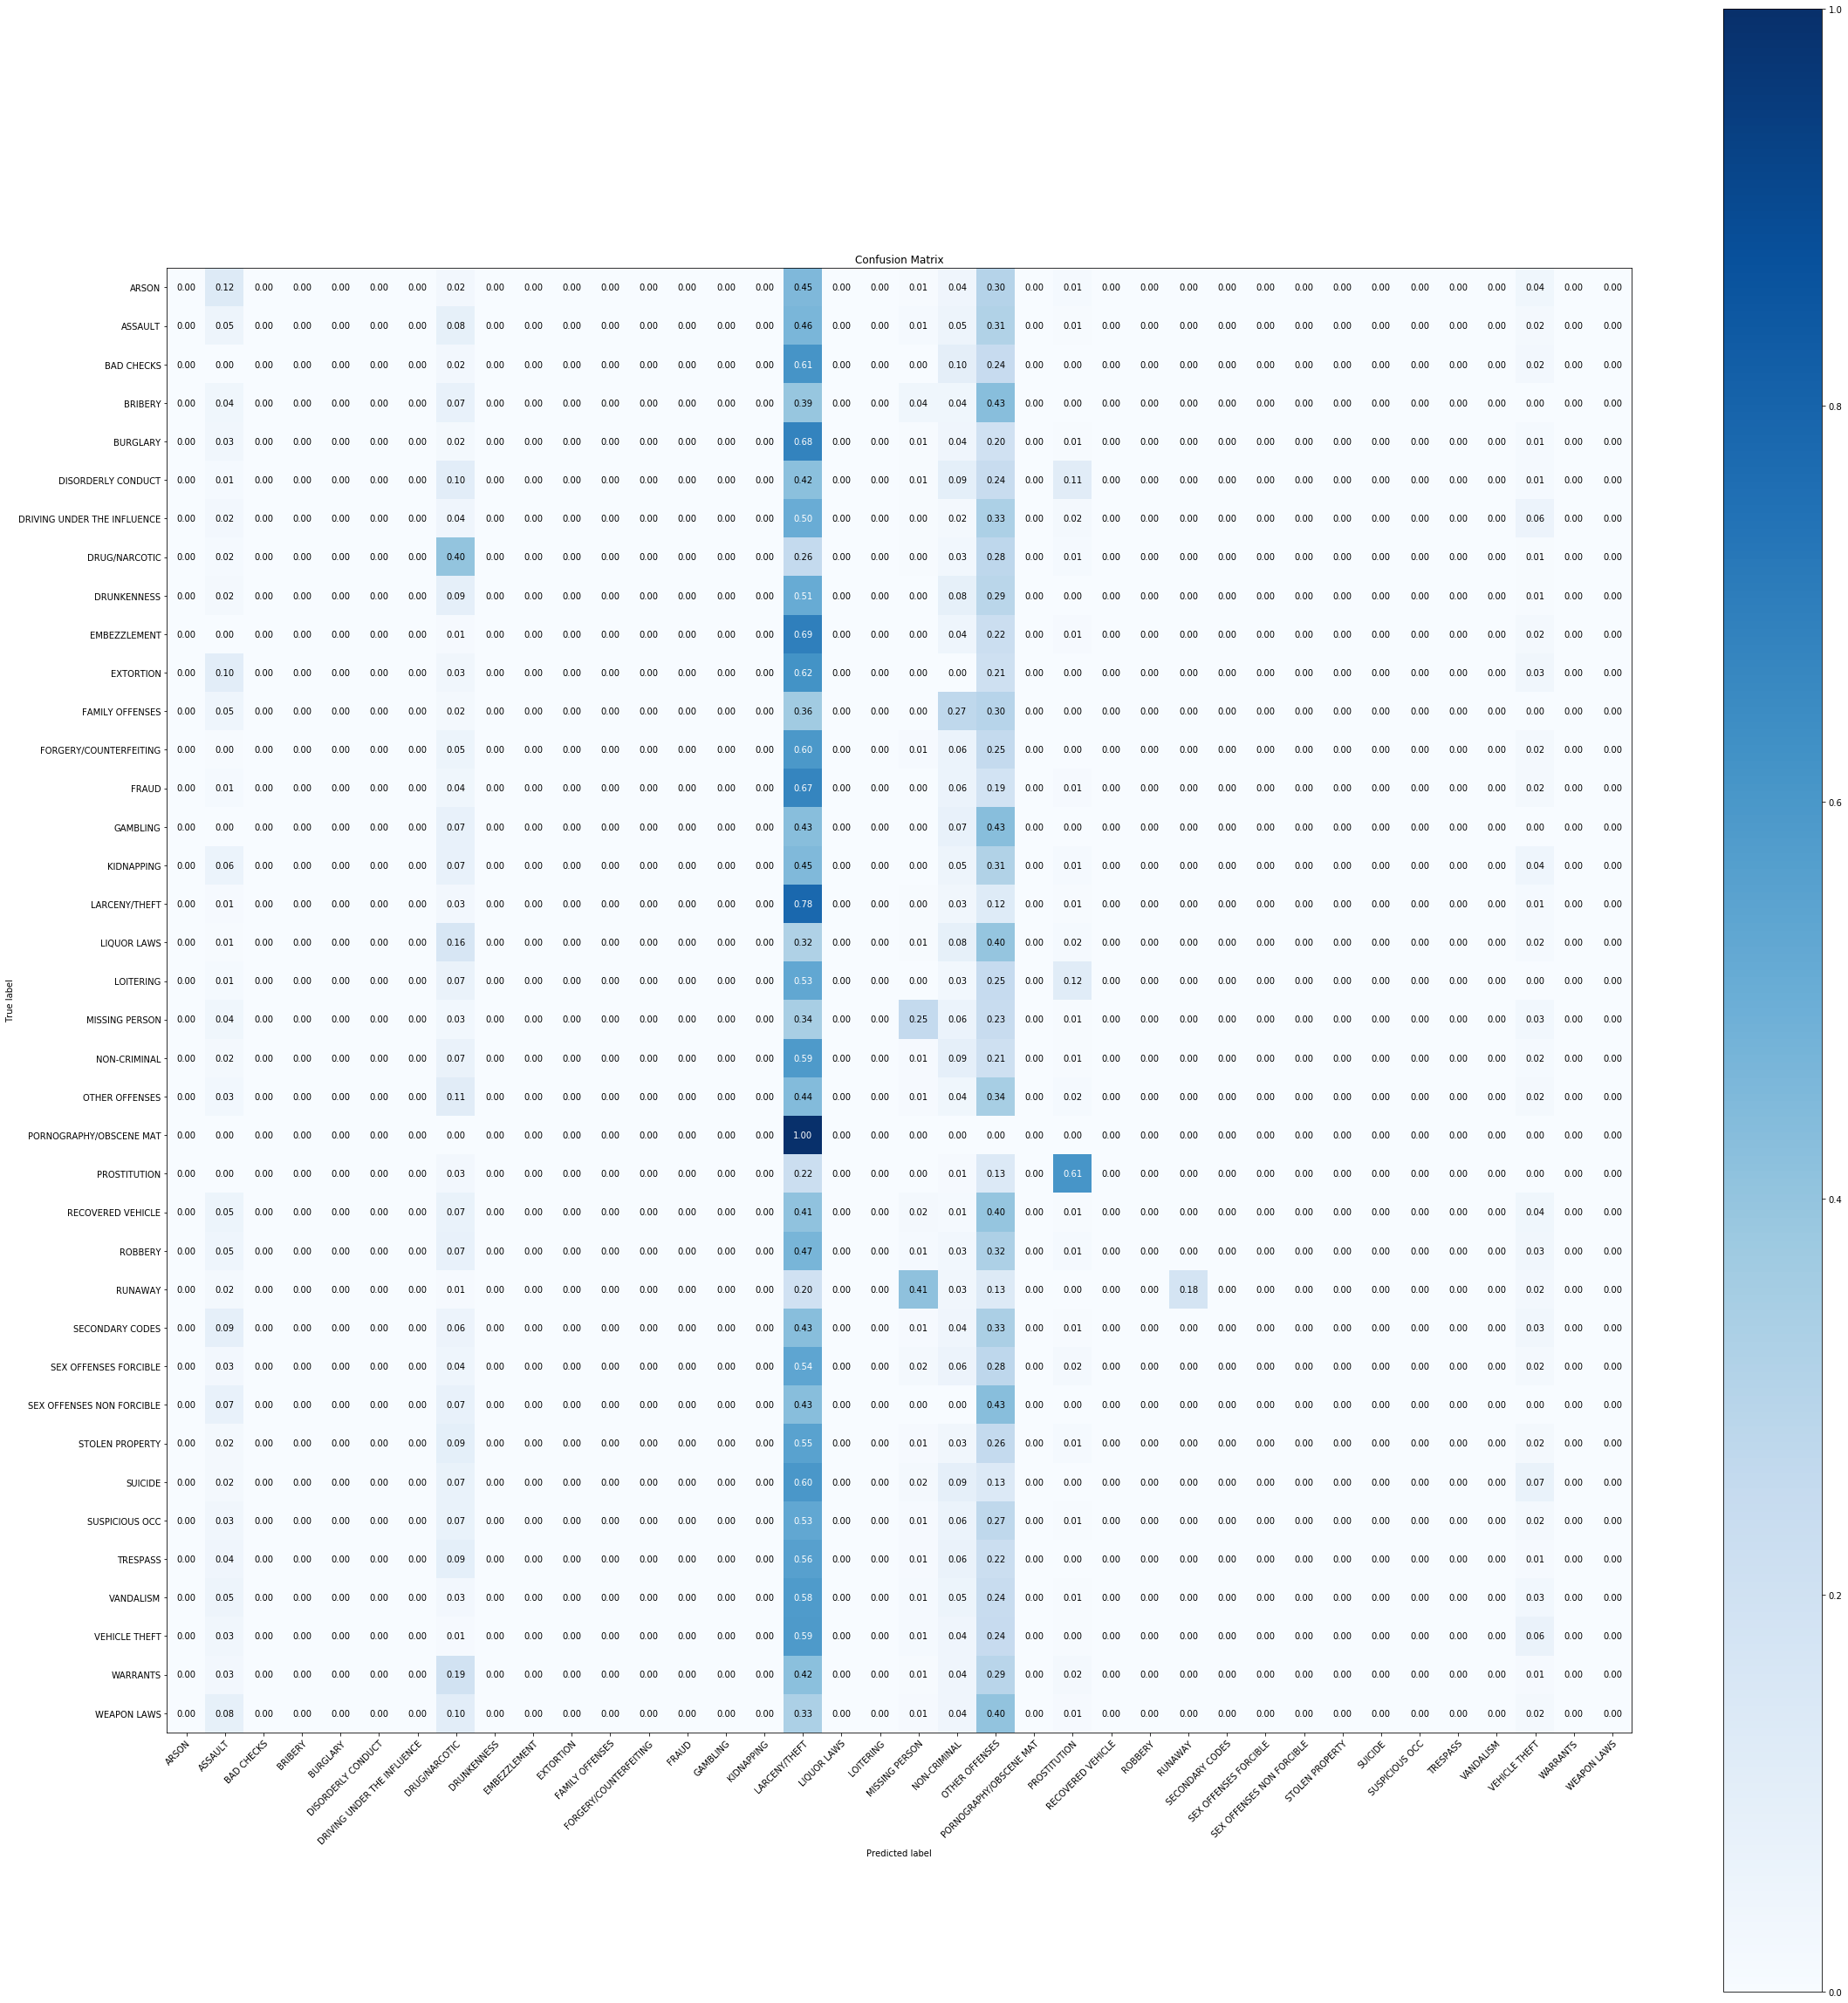

In [49]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title="Confusion Matrix",
                          cmap=plt.cm.Blues):

    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    fig.set_figheight(32)
    fig.set_figwidth(32)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # rotate labels and set alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

ax = plot_confusion_matrix(dev_labels, pred_labels, classes=unique_labels(dev_labels, pred_labels))


In [42]:
pred_labels_train = search.predict(train_data)
train_accuracy = np.mean(train_labels == pred_labels_train)
dev_accuracy = np.mean(dev_labels == pred_labels)
print("train_acc", train_accuracy)
print("dev_acc", dev_accuracy)

train_acc 0.2614116652578191
dev_acc 0.26038380502249303


In [43]:
# plot train vs. dev performance - isabell said don't use accuracy

from sklearn.metrics import log_loss
predsproba_train = search.best_estimator_.predict_proba(train_data)
train_results = log_loss(train_labels, predsproba_train)
print("train_log", train_results)
predsproba_dev = search.best_estimator_.predict_proba(dev_data)
dev_results = log_loss(dev_labels, predsproba_dev, labels=np.unique(train_labels))
print("dev_log", dev_results)

train_log 2.4639990344501337
dev_log 2.4753368842314916


In [46]:
# rerun with Arthur's PCA - nvm no time
from sklearn.decomposition import PCA

pca = PCA(n_components = 25)
pca_dat = pca.fit_transform(train_data)


In [47]:
pca_dat.shape

(790244, 25)

In [28]:
train_accuracy

0.2614116652578191

In [29]:
dev_accuracy

0.26038380502249303

In [30]:
predsproba = search.best_estimator_.predict_proba(test_pd)
print(predsproba[0:3])

[[1.11363928e-02 1.33055384e-01 1.87741737e-04 3.62640148e-04
  2.36839263e-02 1.12403878e-03 6.67414492e-03 4.88563796e-03
  3.84272156e-03 7.83384650e-04 6.33718608e-05 4.67077264e-04
  9.51281705e-03 1.22908162e-02 1.49325479e-05 4.35375718e-03
  1.02859552e-01 7.70951166e-04 5.41893073e-06 1.80137525e-01
  6.84085335e-02 1.28801622e-01 1.49700934e-06 1.31787560e-04
  3.85371513e-03 3.36163675e-02 3.53722648e-03 2.30964770e-02
  8.72262864e-03 6.22217427e-05 2.42026284e-03 1.19556141e-03
  3.91414374e-02 2.50829030e-07 1.40090629e-03 5.90093143e-02
  1.02615692e-01 1.43753001e-02 1.33969672e-02]
 [4.27521982e-03 1.57037342e-01 1.40900588e-04 7.01622802e-04
  1.83675855e-02 1.12118647e-03 6.21179018e-03 5.99194912e-02
  5.15927224e-03 3.02800805e-04 2.69662258e-04 2.95509172e-04
  9.85696428e-03 8.94596925e-03 2.31024987e-04 3.91137276e-03
  5.84469609e-02 1.31068125e-03 8.31647983e-05 1.52958990e-02
  6.29823923e-02 2.49593255e-01 9.14859406e-07 1.06926483e-04
  4.26082528e-03 4.108

In [33]:
# converts predicted probabilities into submission panda
submissions = prep_submissions(predsproba, train_pd.Category, test_ids)

print(submissions.shape)
print(submissions.head(3))

# checks submission has the correct number of rows and columns
sample_submissions = pd.read_csv("../data/raw/sampleSubmission.csv.zip", compression="zip")
assert(sample_submissions.shape[0] == submissions.shape[0])
assert(sample_submissions.shape[1] == submissions.shape[1])

(884262, 40)
       Id  ARSON  ASSAULT  BAD CHECKS  BRIBERY  BURGLARY  DISORDERLY CONDUCT  \
0  191337   0.01     0.13         0.0      0.0      0.02                 0.0   
1  824458   0.00     0.16         0.0      0.0      0.02                 0.0   
2  797412   0.00     0.06         0.0      0.0      0.17                 0.0   

   DRIVING UNDER THE INFLUENCE  DRUG/NARCOTIC  DRUNKENNESS  ...  \
0                         0.01           0.00         0.00  ...   
1                         0.01           0.06         0.01  ...   
2                         0.01           0.01         0.00  ...   

   SEX OFFENSES NON FORCIBLE  STOLEN PROPERTY  SUICIDE  SUSPICIOUS OCC  TREA  \
0                        0.0              0.0      0.0            0.04   0.0   
1                        0.0              0.0      0.0            0.05   0.0   
2                        0.0              0.0      0.0            0.03   0.0   

   TRESPASS  VANDALISM  VEHICLE THEFT  WARRANTS  WEAPON LAWS  
0      0.00  

In [35]:
# save submissions to disk
submissions.to_csv("~/Desktop/w207re-final-proj/datasubmission.csv.gz", index = False, compression = "gzip")

In [48]:
## XBT

from sklearn.ensemble import GradientBoostingClassifier

selector = DataFrameSelector(["X", "Y"])
clf2 = GradientBoostingClassifier(random_state=42, tol=0.01, n_estimators = 100)

pipe = Pipeline([
    ("selector", selector)
    ,("clf", clf2)
])

param_grid = {
    "selector__attribute_names": [
    ["X", "Y", "is_latenight"]
    ]
}

search_xbt = GridSearchCV(pipe, param_grid, iid = True, cv = 3, scoring ='neg_log_loss', return_train_score = False, n_jobs = -1)
_ = search_xbt.fit(train_data, train_labels)

print("Best parameter (CV score=%0.3f):" % search_xbt.best_score_)
print(search_xbt.best_params_)


Best parameter (CV score=-2.494):
{'selector__attribute_names': ['X', 'Y', 'is_latenight']}


In [50]:
predsproba_train_xbt = search_xbt.best_estimator_.predict_proba(train_data)
train_results_xbt = log_loss(train_labels, predsproba_train_xbt)
print("train_log", train_results_xbt)
predsproba_dev_xbt = search_xbt.best_estimator_.predict_proba(dev_data)
dev_results_xbt = log_loss(dev_labels, predsproba_dev_xbt, labels=np.unique(train_labels))
print("dev_log", dev_results_xbt)

train_log 2.4824717627446993
dev_log 2.489170168455521


In [54]:
predsproba_xbt = search_xbt.best_estimator_.predict_proba(test_pd)
print(predsproba_xbt[0:3])

[[5.37280155e-03 1.10943926e-01 4.28385492e-04 1.04856384e-03
  3.88309382e-02 2.35706015e-03 5.92408472e-03 2.10692783e-02
  2.93989235e-03 1.28446200e-03 2.10486599e-04 7.25684612e-04
  9.21635581e-03 1.21295028e-02 1.23026794e-04 4.39642123e-03
  1.10661350e-01 8.83619358e-04 4.38735966e-04 4.50490877e-02
  7.26387793e-02 1.74511168e-01 1.70273272e-05 6.25566910e-04
  6.74351540e-03 4.87800184e-02 2.84273345e-03 1.24093916e-02
  6.00620657e-03 2.51360723e-04 4.30652673e-03 4.88151567e-04
  4.25517056e-02 3.88712187e-06 4.56175761e-03 7.12043648e-02
  1.29524367e-01 3.37707843e-02 1.47290238e-02]
 [6.94837412e-03 1.24609911e-01 1.84185921e-04 5.52755387e-04
  2.73639780e-02 1.97533461e-03 4.52523985e-03 5.73186786e-02
  3.86194535e-03 9.49822176e-04 1.79776944e-04 7.62659033e-04
  6.58746560e-03 9.49262920e-03 1.55757763e-04 3.62581239e-03
  8.14299722e-02 2.34940646e-03 5.68987176e-04 3.29240038e-02
  6.03801175e-02 2.33508511e-01 1.50556658e-05 5.53130050e-04
  5.11402281e-03 3.918

In [55]:
# converts predicted probabilities into submission panda
submissions_xbt = prep_submissions(predsproba_xbt, train_pd.Category, test_ids)

print(submissions_xbt.shape)
print(submissions_xbt.head(3))

# checks submission has the correct number of rows and columns
sample_submissions = pd.read_csv("../data/raw/sampleSubmission.csv.zip", compression="zip")
assert(sample_submissions.shape[0] == submissions_xbt.shape[0])
assert(sample_submissions.shape[1] == submissions_xbt.shape[1])

(884262, 40)
       Id  ARSON  ASSAULT  BAD CHECKS  BRIBERY  BURGLARY  DISORDERLY CONDUCT  \
0  191337   0.01     0.11         0.0      0.0      0.04                 0.0   
1  824458   0.01     0.12         0.0      0.0      0.03                 0.0   
2  797412   0.00     0.06         0.0      0.0      0.10                 0.0   

   DRIVING UNDER THE INFLUENCE  DRUG/NARCOTIC  DRUNKENNESS  ...  \
0                         0.01           0.02          0.0  ...   
1                         0.00           0.06          0.0  ...   
2                         0.00           0.02          0.0  ...   

   SEX OFFENSES NON FORCIBLE  STOLEN PROPERTY  SUICIDE  SUSPICIOUS OCC  TREA  \
0                        0.0             0.00      0.0            0.04   0.0   
1                        0.0             0.00      0.0            0.04   0.0   
2                        0.0             0.01      0.0            0.03   0.0   

   TRESPASS  VANDALISM  VEHICLE THEFT  WARRANTS  WEAPON LAWS  
0      0.00  

In [57]:
# save submissions to disk
submissions_xbt.to_csv("~/Desktop/w207re-final-proj/datasubmissionxbt.csv.gz", index = False, compression = "gzip")